# Install extra dependencies

In [1]:
!pip install -q torchinfo

# get filepaths

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from torchinfo import summary
import os

USE_KAGGLE = False

if USE_KAGGLE:
    datapath = os.path.join("/kaggle", "input", "cityscapes-image-pairs", "cityscapes_data")
else:
    datapath = os.path.join("dataset", "cityscapes_data")

train_datapath = os.path.join(datapath, "train")
val_datapath = os.path.join(datapath, "val")

train_cs_datapath = os.path.join(datapath, "cityscapes_data", "train")
val_cs_datapath = os.path.join(datapath, "cityscapes_data", "val")

training_images_paths = [os.path.join(train_datapath, f) for f in os.listdir(train_datapath)]
validation_images_paths = [os.path.join(val_datapath, f) for f in os.listdir(val_datapath)]


print(f"size of training : {len(training_images_paths)}")
print(f"size of cityscapes training : {len(os.listdir(train_cs_datapath))}")
print(f"size of validation : {len(validation_images_paths)}")
print(f"size of cityscapes validation : {len(os.listdir(val_cs_datapath))}")

global_step = 0

size of training : 2975
size of cityscapes training : 2975
size of validation : 500
size of cityscapes validation : 500


# Data visualization

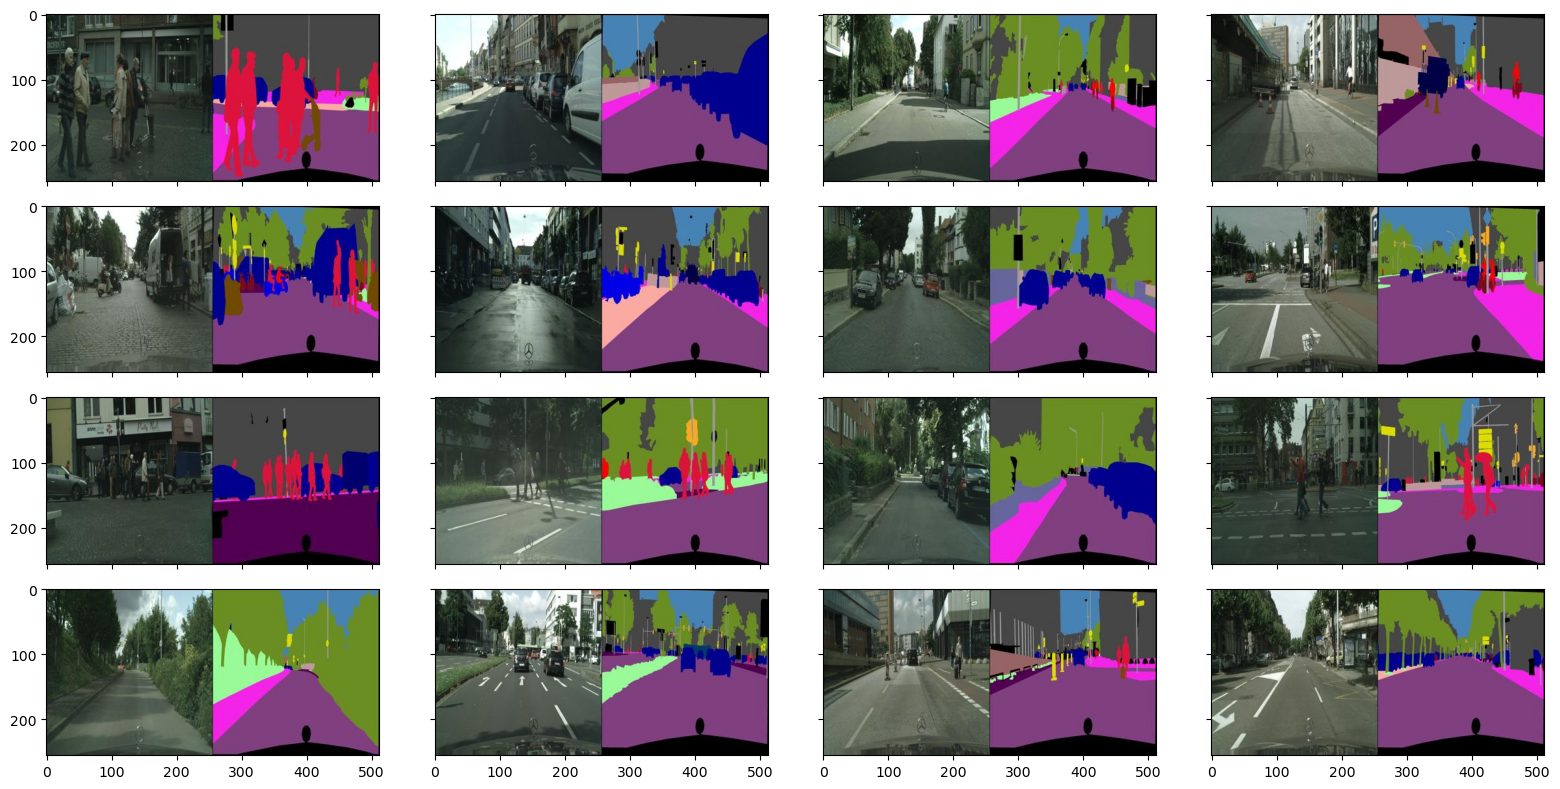

In [3]:
import torchvision
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

width = 4
height = 4
vis_batch_size = width * height

indexes = np.arange(len(training_images_paths))
indexes = np.random.permutation(indexes)[:vis_batch_size]
fig, axs = plt.subplots(height, width, sharex=True, sharey=True, figsize=(16, 8))

for i in range(vis_batch_size):
    img = torchvision.io.read_image(training_images_paths[indexes[i]])
    img = img.permute(1, 2, 0)
    
    # plt.subplot(height, width, i + 1)
    y, x = i // width, i % width
    
    axs[y, x].imshow(img.numpy())
    
plt.tight_layout()

# Data preprocessing

## labels 

In [4]:
from PIL import Image

# reference
# link : https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
idx_to_name = [ 'unlabeled','ego vehicle','rectification border', 'out of roi', 'static', 'dynamic','ground', 'road', 'sidewalk', 'parking', 'rail track', 'building', 'wall', 'fence','guard rail' , 'bridge','tunnel','pole', 'polegroup', 'traffic light', 'traffic sign' ,'vegetation', 'terrain', 'sky' ,'person', 'rider', 'car','truck' ,'bus', 'caravan','trailer', 'train' , 'motorcycle','bicycle','license plate']
idx_to_category = ["void", "flat", "construction", "object", "nature", "sky", "human", "vehicle"]

idx_to_color = [[ 0,  0,  0], [ 0,  0,  0], [  0,  0,  0], [  0,  0,  0],[ 0,  0,  0],[111, 74,  0],[81,  0, 81] ,[128, 64,128],[244, 35,232],
                [250,170,160],[230,150,140],[70, 70, 70],[102,102,156],[190,153,153],[180,165,180],[150,100,100],[150,120, 90],[153,153,153],
                [153,153,153],[250,170, 30],[220,220,  0],[107,142, 35],[152,251,152],[ 70,130,180],[220, 20, 60],[255,  0,  0],[ 0,  0,142],
                [ 0,  0, 70],[ 0, 60,100],[ 0,  0, 90],[  0,  0,110],[ 0, 80,100],[  0,  0,230],[119, 11, 32],[  0,  0,142]]


idx_to_color_np = np.array(idx_to_color)

name_to_category = {0 : 0, 1 : 0, 2 : 0, 3: 0, 4 : 0, 5 : 0, 6 : 0, 7 : 1, 8 : 1, 9 : 1, 10 : 1, 11 :2, 12 : 2, 13 : 2, 14 : 2, 15 : 2, 16 : 2,
                    17 : 3, 18 : 3, 19 : 3, 20: 3, 21 : 4, 22 : 4, 23 : 5, 24 : 6, 25 : 6, 26 : 7, 27 : 7, 28 : 7, 29 : 7, 30 : 7, 31 : 7, 32: 7, 33 : 7, 34 : 7}

## Image processing

size of input :  (128, 128, 3)
size of mask raw :  (128, 128, 3)
size of classes :  (128, 128)


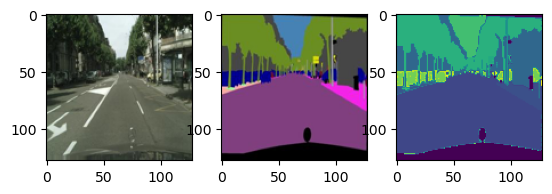

In [5]:
name_to_category_mapping = lambda x: name_to_category[x]
vectorized_cat_mapping = np.vectorize(name_to_category_mapping)

name_to_col_mapping = lambda x: idx_to_color[x]
vectorized_col_mapping = np.vectorize(name_to_col_mapping)

def preprocess_image(path, sparse_mapping=True, downscale_factor=None):
    # read the numpy data from jpeg image
    img = Image.open(path)
    
    width, height = img.size

    if downscale_factor:
        width, height = width // downscale_factor, height//downscale_factor 
        img = img.resize(( width, height ))

    img = np.asarray(img)
    
    raw, mask = img[:, :width//2, :], img[:, width//2:, :]
    
    height, width, channels = mask.shape
    
    distances = np.sum((mask.reshape(-1, channels)[:, np.newaxis, :] - idx_to_color_np)**2, axis=2)
    classes = np.argmin(distances, axis=1).reshape(height, width)
    
    if sparse_mapping:
        classes = vectorized_cat_mapping(classes)
    
    return raw, mask, classes

#                                                                                                necessary for kaggle
#                                                                                                otherwise images 256x256 are very slow
#                                                                                                and will crash due to RAM requirements
x, mask_raw, classes = preprocess_image(training_images_paths[indexes[i]], sparse_mapping=False, downscale_factor=2)

print("size of input : ", x.shape)
print("size of mask raw : ", mask_raw.shape)
print("size of classes : ", classes.shape)
plt.subplot(1, 3, 1)
plt.imshow(x)
plt.subplot(1, 3, 2)
plt.imshow(mask_raw)
plt.subplot(1, 3, 3)
plt.imshow(classes)
plt.show()

# Load data and Pytorch dataset

## Load dataset

In [6]:
from tqdm.auto import tqdm

train_images_to_use = -1

# for kaggle
downscale_factor=None

X_train, Y_train = [], []
X_val, Y_val = [], []

for path in tqdm(training_images_paths[:]):
    X, _, Y = preprocess_image(path, downscale_factor=downscale_factor)
    X_train.append(torch.Tensor(X / 255.).permute(2, 0, 1))
    Y_train.append(torch.Tensor(Y))

for path in tqdm(validation_images_paths):
    X, _, Y = preprocess_image(path, downscale_factor=downscale_factor)
    X_val.append(torch.Tensor(X / 255.).permute(2, 0, 1))
    Y_val.append(torch.Tensor(Y))

  0%|          | 0/2975 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

## Pytorch Dataset

In [7]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CityScapesDataset(Dataset):
    def __init__(self, X, Y, transform=None, target_transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x, y = self.X[idx], self.Y[idx]

        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
        return x , y

train_ds = CityScapesDataset(X_train, Y_train)
val_ds = CityScapesDataset(X_val, Y_val)

train_dataloader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=8, shuffle=True)

## Test dataset

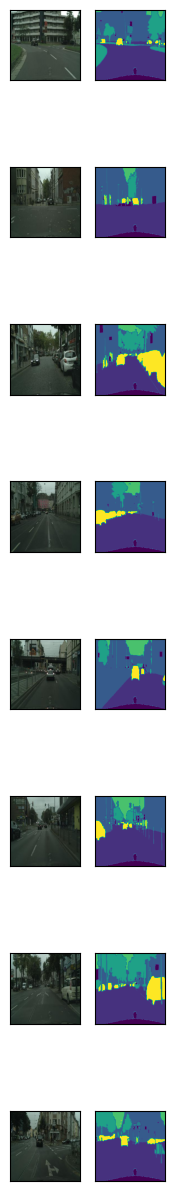

In [9]:
batch_size = 8

plt.figure(figsize=(2, 2 * batch_size))
for i in range(8):
    img, mask = X_train[i], Y_train[i]  
    #print(img.shape, mask.shape)
    plt.subplot(batch_size, 2, 2 * i + 1)
    plt.imshow(img.permute(1,2, 0))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(batch_size, 2, 2 * i + 2)
    plt.imshow(mask)
    plt.xticks([])
    plt.yticks([])
    

torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256])


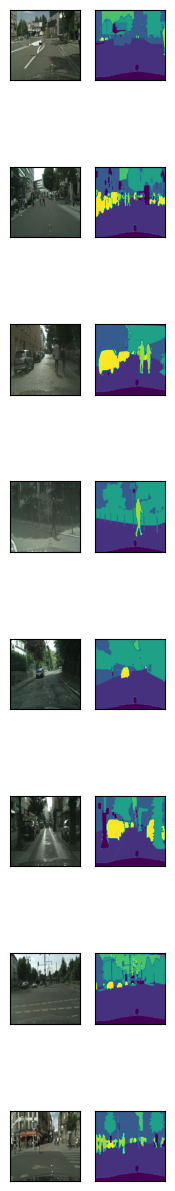

In [10]:
batch = next(iter(train_dataloader))

print(batch[0].shape, batch[1].shape)
batch_size = batch[0].shape[0]

plt.figure(figsize=(2, 2 * batch_size))
for i in range(batch_size):
    img, mask = batch[0][i], batch[1][i]  
    #print(img.shape, mask.shape)
    plt.subplot(batch_size, 2, 2 * i + 1)
    plt.imshow(img.permute(1,2, 0))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(batch_size, 2, 2 * i + 2)
    plt.imshow(mask)
    plt.xticks([])
    plt.yticks([])
    

# Pytorch util training

## Extra Losses

In [12]:
# dice loss : https://github.com/milesial/Pytorch-UNet/blob/master/utils/dice_score.py

from torch import Tensor

def dice_coeff(inp : Tensor, tgt : Tensor, eps=1e-6):
    sum_dim = (-1, -2, -3)
    
    inter = 2 *(inp * tgt).sum(dim=sum_dim)
    sets_sum = inp.sum(dim=sum_dim) + tgt.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)
    
    dice = (inter + eps) / (sets_sum + eps)
    return dice.mean()

def multiclass_dice_coeff(input: Tensor, target: Tensor, eps: float = 1e-6):
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), eps)

def dice_loss(input: Tensor, target: Tensor):
    # Dice loss (objective to minimize) between 0 and 1
    return 1 - multiclass_dice_coeff(input, target)

def IoU_coeff(inp : Tensor, tgt : Tensor, eps = 1e-6):
    sum_dim = (-1, -2, -3)
    
    # Intersection term  |A ^ B|
    inter = (inp * tgt).sum(dim=sum_dim)
    
    # sum of |A| + |B|
    sets_sum = inp.sum(dim=sum_dim) + tgt.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)
    
    # IoU = |A ^ B| / |A \/ B| = |A ^ B| / (|A| + |B| - |A^B|)
    
    return (inter + eps) / (sets_sum - inter + eps)

def IoU_loss(inp : Tensor, tgt : Tensor):
    return 1 - IoU_coeff(inp.flatten(0,1), tgt.flatten(0,1))

## Training / Eval code

In [13]:
import torch.optim as optim

epoch_to_fig = []

def evaluate_model(model, val_dataloader, epoch, epochs, criterion,
                   with_dice_loss=True, with_IoU_loss=False, save_figs=True):
    global epoch_to_fig 
    val_loss = 0
    training_dice = 0
    training_IoU = 0
    with tqdm(val_dataloader, desc=f"Epoch {epoch}/{epochs} ; val Loss 0") as pbar:
        model.eval()
        examples_so_far = 0
        for i, batch in enumerate(val_dataloader):
            images, true_masks = batch[0], batch[1]
                
            images = images.to(device)
            true_masks = true_masks.to(device).long()                
                
            # predictions
            masks_pred = model(images)
            
            loss = criterion(masks_pred, true_masks)
            val_loss += loss.item() * images.shape[0]
            examples_so_far += images.shape[0]

            dice = dice_loss(F.softmax(masks_pred, dim=1).float(),
                             F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
            
            if with_dice_loss:
                loss += dice
            training_dice += images.shape[0] * (1.-dice.item())
                
            IoU = IoU_loss(F.softmax(masks_pred, dim=1).float(),
                           F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
            
            if with_IoU_loss:
                loss += IoU
            training_IoU += images.shape[0] * (1.-IoU.item())
            
            pbar.update(1)
                
            descr = f"Epoch {epoch}/{epochs} ; val Loss {round(val_loss / examples_so_far ,3)}, val IoU : {round(training_IoU / examples_so_far ,3)}, val Dice : {round(training_dice / examples_so_far ,3)}"               
            pbar.set_description(descr)
    
    if save_figs:
        val_batch = next(iter(val_dataloader))
        images = val_batch[0].to(device)

        true_classes = val_batch[1]
        true_classes = torch.stack([true_classes, true_classes, true_classes]).permute(1, 2, 3, 0) / (number_of_classes-1)

        preds = model(images)
        pred_classes = torch.argmax(preds.permute(0,2,3,1), dim=3)
        pred_classes = torch.stack([pred_classes, pred_classes, pred_classes]).permute(1, 2, 3, 0) / (number_of_classes-1)

        scale = 5
        batch_size = pred_classes.shape[0]

        images = images.permute(0,2,3,1)
        pred_true = torch.cat([images.to("cpu"), pred_classes.to("cpu"), true_classes.to("cpu")], dim=2)


        to_vis = pred_true.reshape(-1, pred_true.shape[2], pred_true.shape[3])
        epoch_to_fig.append(to_vis)

def train_model(model, device, train_dataloader,
                val_dataloader, epochs=10, lr=1e-4, update_pb_every_batch = 1,
                with_dice_loss=True, with_IoU_loss=False):
    global global_step
    
    # setup the optimizer, loss, learning rate scheduler
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(1, epochs + 1):
        
        training_loss = 0
        training_dice = 0
        training_IoU = 0
        with tqdm(train_dataloader, desc=f"Epoch {epoch}/{epochs} ; training Loss {round(training_loss,3)}") as pbar:
            model.train()
            optimizer.zero_grad()
            examples_so_far = 0
            for i,batch in enumerate(train_dataloader):
                images, true_masks = batch[0], batch[1]
                
                images = images.to(device)
                true_masks = true_masks.to(device).long()
                                
                masks_pred = model(images)
                
                loss = criterion(masks_pred, true_masks)
                if with_dice_loss:
                    dice = dice_loss(F.softmax(masks_pred, dim=1).float(),
                              F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
                    loss += dice
                    training_dice += images.shape[0] * (1.-dice.item())
                
                if with_IoU_loss:
                    IoU = IoU_loss(F.softmax(masks_pred, dim=1).float(),
                              F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
                    loss += IoU
                    training_IoU += images.shape[0] * (1.-IoU.item())
                
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                global_step += 1
                training_loss += images.shape[0] * loss.item()
                examples_so_far += images.shape[0]

                pbar.update(1)
                if i % update_pb_every_batch == 0:
                    descr = f"Epoch {epoch}/{epochs} ; training Loss {round(training_loss / examples_so_far ,3)}"        
                    if with_dice_loss:
                        descr = f"Epoch {epoch}/{epochs} ; training Loss {round(training_loss / examples_so_far ,3)}, avg DICE : {round(training_dice / examples_so_far ,3)}"   
                    elif with_IoU_loss:
                        descr = f"Epoch {epoch}/{epochs} ; training Loss {round(training_loss / examples_so_far ,3)}, avg IoU : {round(training_IoU / examples_so_far ,3)}"
                    
                    pbar.set_description(descr)
        
        evaluate_model(model, val_dataloader, epoch, epochs, criterion, with_dice_loss=with_dice_loss, with_IoU_loss=with_IoU_loss)

# Unet

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F 

class DoubleConv(nn.Module):
    """ Conv2d -> BatchNorm2d - Relu -> Conv2d -> BatchNorm2d -> Relu """
    
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
            
        self.double_conv = nn.Sequential(nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
                                         nn.BatchNorm2d(mid_channels),
                                         nn.ReLU(inplace=True),
                                         nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
                                         nn.BatchNorm2d(out_channels),
                                         nn.ReLU(inplace=True))
    
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(nn.MaxPool2d(2),
                                          DoubleConv(in_channels, out_channels))
    
    def forward(self, x):
        return self.maxpool_conv(x)
    

class Up(nn.Module):
    """Upscaling then double conv"""
    
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is (batch, channel, height, width)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        return self.conv(x)
    

class Unet(nn.Module):
    def __init__(self, n_channels, n_classes, start=32, bilinear=False):
        super(Unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, start)
        self.down1 = Down(start, 2*start)
        self.down2 = Down(2*start, 4*start)
        self.down3 = Down(4*start, 8*start)
        
        factor = 2 if bilinear else 1
        self.down4 = Down(8*start, 16*start // factor)
        
        self.up1 = Up(16*start, 8*start // factor, bilinear)
        self.up2 = Up(8*start, 4*start // factor, bilinear)
        self.up3 = Up(4*start, 2*start // factor, bilinear)
        self.up4 = Up(2*start, start, bilinear)
        self.outc = OutConv(start, n_classes)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits
    

number_of_classes = len(set(name_to_category.values()))
summary(Unet(3, number_of_classes), input_data=batch[0])

Layer (type:depth-idx)                        Output Shape              Param #
Unet                                          [8, 8, 256, 256]          --
├─DoubleConv: 1-1                             [8, 32, 256, 256]         --
│    └─Sequential: 2-1                        [8, 32, 256, 256]         --
│    │    └─Conv2d: 3-1                       [8, 32, 256, 256]         864
│    │    └─BatchNorm2d: 3-2                  [8, 32, 256, 256]         64
│    │    └─ReLU: 3-3                         [8, 32, 256, 256]         --
│    │    └─Conv2d: 3-4                       [8, 32, 256, 256]         9,216
│    │    └─BatchNorm2d: 3-5                  [8, 32, 256, 256]         64
│    │    └─ReLU: 3-6                         [8, 32, 256, 256]         --
├─Down: 1-2                                   [8, 64, 128, 128]         --
│    └─Sequential: 2-2                        [8, 64, 128, 128]         --
│    │    └─MaxPool2d: 3-7                    [8, 32, 128, 128]         --
│    │    └─Doub

In [14]:
device = "cuda"
model = Unet(3, number_of_classes)
model = model.to(device)

train_model(model, device, train_dataloader, val_dataloader, update_pb_every_batch=10)

Epoch 1/10 ; training Loss 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 1/10 ; val Loss 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/10 ; training Loss 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 2/10 ; val Loss 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/10 ; training Loss 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 3/10 ; val Loss 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/10 ; training Loss 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 4/10 ; val Loss 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/10 ; training Loss 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 5/10 ; val Loss 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/10 ; training Loss 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 6/10 ; val Loss 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/10 ; training Loss 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 7/10 ; val Loss 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/10 ; training Loss 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 8/10 ; val Loss 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/10 ; training Loss 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 9/10 ; val Loss 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/10 ; training Loss 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 10/10 ; val Loss 0:   0%|          | 0/63 [00:00<?, ?it/s]

# ESNET

In [17]:
import torch
import torch.nn as nn

# from : https://arxiv.org/pdf/1906.09826.pdf
class FCU(nn.Module):
    def __init__(self, K, channels, activ_fun=nn.ReLU):
        super(FCU, self).__init__()        
        self.pad = K // 2
        self.conv11  = nn.Conv2d(channels, channels, kernel_size=(K, 1), stride=1, padding=(self.pad,0))
        self.activ12 = activ_fun()
        
        self.conv21  = nn.Conv2d(channels, channels, kernel_size=(1, K), stride=1, padding=(0, self.pad))
        self.bn2d22  = nn.BatchNorm2d(channels)
        self.activ23 = activ_fun()
        
        self.conv31  = nn.Conv2d(channels, channels, kernel_size=(K, 1), stride=1, padding=(self.pad,0))
        self.activ32 = activ_fun()
    
        self.conv41  = nn.Conv2d(channels, channels, kernel_size=(1, K), stride=1, padding=(0, self.pad))
        self.bn2d42  = nn.BatchNorm2d(channels)
        
        self.final   = activ_fun()
    
    def forward(self, x):
        fwd = self.conv11(x)
        fwd = self.activ12(fwd)
        
        fwd = self.conv21(fwd)
        fwd = self.bn2d22(fwd)
        fwd = self.activ23(fwd)
        
        fwd = self.conv31(fwd)
        fwd = self.activ32(fwd)
        
        fwd = self.conv41(fwd)
        fwd = self.bn2d42(fwd)

        return self.final(x + fwd)
    
    
    
# from : https://arxiv.org/pdf/1906.09826.pdf
class PFCU(nn.Module):
    def __init__(self, K, channels, r1=2, r2=5, r3=9, activ_fun=nn.ReLU):
        super(PFCU, self).__init__()
        self.pad = (K - 1) // 2
        
        self.conv1  = nn.Conv2d(channels, channels, kernel_size=(K, 1), stride=1, padding=(self.pad, 0))
        self.activ1 = activ_fun()
        
        self.conv2  = nn.Conv2d(channels, channels, kernel_size=(1, K), stride=1, padding=(0, self.pad))
        self.bn2d1  = nn.BatchNorm2d(channels)
        self.activ2 = activ_fun()
        
        # left dilated block
        self.conv_ld_1  = nn.Conv2d(channels, channels, kernel_size=(K, 1), stride=1, padding=(self.pad + r1 -1, 0), dilation=r1)
        self.activ_ld_1 = activ_fun()
        self.conv_ld_2  = nn.Conv2d(channels, channels, kernel_size=(1, K), stride=1, padding=(0, self.pad + r1 - 1), dilation=r1)
        self.bn2d_ld_1  = nn.BatchNorm2d(channels)
        
        # middle dilated block
        self.conv_md_1  = nn.Conv2d(channels, channels, kernel_size=(K, 1), stride=1, padding=(self.pad + r2 -1, 0), dilation=r2)
        self.activ_md_1 = activ_fun()
        self.conv_md_2  = nn.Conv2d(channels, channels, kernel_size=(1, K), stride=1, padding=(0, self.pad + r2 - 1), dilation=r2)
        self.bn2d_md_1  = nn.BatchNorm2d(channels)    
        
        # right dilated block
        self.conv_rd_1  = nn.Conv2d(channels, channels, kernel_size=(K, 1), stride=1, padding=(self.pad + r3 - 1, 0), dilation=r3)
        self.activ_rd_1 = activ_fun()
        self.conv_rd_2  = nn.Conv2d(channels, channels, kernel_size=(1, K), stride=1, padding=(0, self.pad + r3 - 1), dilation=r3)
        self.bn2d_rd_1  = nn.BatchNorm2d(channels)    
        
        self.final = activ_fun()
        
    def forward(self, x):
        fwd = self.conv1(x)
        fwd = self.activ1(fwd)
        
        fwd = self.conv2(fwd)
        fwd = self.bn2d1(fwd)
        fwd = self.activ2(fwd)
        
        # pass through left block
        fwd_l = self.conv_ld_1(fwd)
        fwd_l = self.activ_ld_1(fwd_l)
        fwd_l = self.conv_ld_2(fwd_l)
        fwd_l = self.bn2d_ld_1(fwd_l)

        # pass through middle block
        fwd_m = self.conv_md_1(fwd)
        fwd_m = self.activ_md_1(fwd_m)
        fwd_m = self.conv_md_2(fwd_m)
        fwd_m = self.bn2d_md_1(fwd_m)
        
        # pass thourgh right block
        fwd_r = self.conv_rd_1(fwd)
        fwd_r = self.activ_rd_1(fwd_r)
        fwd_r = self.conv_rd_2(fwd_r)
        fwd_r = self.bn2d_rd_1(fwd_r)
        
        
        # return activ( x + fwd_left + fwd_middle + fwd_right)
        return self.final(x + fwd_l + fwd_m + fwd_r)
        

# from : https://arxiv.org/pdf/1905.02423.pdf
class DownSamplingUnit(nn.Module):
    def __init__(self, input_channels, out_channels, activation=nn.ReLU):
        super(DownSamplingUnit, self).__init__()
        self.pool  = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.conv  = nn.Conv2d(input_channels, out_channels - input_channels, kernel_size=3, padding=1, stride=2)
        self.bn    = nn.BatchNorm2d(out_channels)
        self.final = activation()
    
    def forward(self, x):
        
        fwd1 = self.pool(x)
        
        fwd2 = self.conv(x)
        
        fwd  = torch.cat((fwd1, fwd2), axis=1)
        fwd  = self.bn(fwd)
        fwd  = self.final(fwd) 
        
        return fwd

class UpSamplingUnit(nn.Module):
    def __init__(self, input_channels, out_channels, activation=nn.ReLU):
        super(UpSamplingUnit, self).__init__()
        self.convTranspose = nn.ConvTranspose2d(input_channels, out_channels, (2, 2), (2,2))
        self.bn = nn.BatchNorm2d(out_channels)
        self.activ = activation()

    def forward(self, x):
        x = self.convTranspose(x)
        x = self.bn(x)
        return self.activ(x)
    
# implementation of the ESNET paper here : https://arxiv.org/pdf/1906.09826.pdf
class ESNet(nn.Module):
    def __init__(self, inp_channels, C):
        super(ESNet, self).__init__()
        self.downsample1 = DownSamplingUnit(inp_channels, 16)
        self.FCU11       = FCU(3, 16)
        self.FCU12       = FCU(3, 16)
        self.FCU13       = FCU(3, 16)
        
        self.downsample2 = DownSamplingUnit(16, 64)
        self.FCU21       = FCU(5, 64)
        self.FCU22       = FCU(5, 64)
        
        self.downsample3 = DownSamplingUnit(64, 128)
        self.PFCU31      = PFCU(3, 128)
        self.PFCU32      = PFCU(3, 128)
        self.PFCU33      = PFCU(3, 128)
        
        self.upsample4   = UpSamplingUnit(128, 64)
        self.FCU41       = FCU(5, 64)
        self.FCU42       = FCU(5, 64)
        
        self.upsample5   = UpSamplingUnit(64, 32)
        self.FCU51       = FCU(3, 32)
        self.FCU52       = FCU(3, 32)
        
        self.upsample6   = UpSamplingUnit(32, C)
        
    def forward(self, x):
        x = self.downsample1(x)
        x = self.FCU11(x)
        x = self.FCU12(x)
        x = self.FCU13(x)
        
        x = self.downsample2(x)
        x = self.FCU21(x)
        x = self.FCU22(x)
        
        x = self.downsample3(x)
        x = self.PFCU31(x)
        x = self.PFCU32(x)
        x = self.PFCU33(x)
        
        x = self.upsample4(x)
        x = self.FCU41(x)
        x = self.FCU42(x)
        
        x = self.upsample5(x)
        x = self.FCU51(x)
        x = self.FCU52(x)
        
        return self.upsample6(x)
    
    
number_of_classes = len(set(name_to_category.values()))
summary(ESNet(3, number_of_classes), input_data=batch[0])

Layer (type:depth-idx)                   Output Shape              Param #
ESNet                                    [8, 8, 256, 256]          --
├─DownSamplingUnit: 1-1                  [8, 16, 128, 128]         --
│    └─MaxPool2d: 2-1                    [8, 3, 128, 128]          --
│    └─Conv2d: 2-2                       [8, 13, 128, 128]         364
│    └─BatchNorm2d: 2-3                  [8, 16, 128, 128]         32
│    └─ReLU: 2-4                         [8, 16, 128, 128]         --
├─FCU: 1-2                               [8, 16, 128, 128]         --
│    └─Conv2d: 2-5                       [8, 16, 128, 128]         784
│    └─ReLU: 2-6                         [8, 16, 128, 128]         --
│    └─Conv2d: 2-7                       [8, 16, 128, 128]         784
│    └─BatchNorm2d: 2-8                  [8, 16, 128, 128]         32
│    └─ReLU: 2-9                         [8, 16, 128, 128]         --
│    └─Conv2d: 2-10                      [8, 16, 128, 128]         784
│    └─ReLU

In [18]:
device = "cuda"
model = ESNet(3, number_of_classes)
model = model.to(device)

train_model(model, device, train_dataloader, val_dataloader, update_pb_every_batch=10)

Epoch 1/10 ; training Loss 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 1/10 ; val Loss 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/10 ; training Loss 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 2/10 ; val Loss 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/10 ; training Loss 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 3/10 ; val Loss 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/10 ; training Loss 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 4/10 ; val Loss 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/10 ; training Loss 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 5/10 ; val Loss 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/10 ; training Loss 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 6/10 ; val Loss 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/10 ; training Loss 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 7/10 ; val Loss 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/10 ; training Loss 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 8/10 ; val Loss 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/10 ; training Loss 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 9/10 ; val Loss 0:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/10 ; training Loss 0:   0%|          | 0/372 [00:00<?, ?it/s]

Epoch 10/10 ; val Loss 0:   0%|          | 0/63 [00:00<?, ?it/s]

# ENet

In [21]:
class InitialBlock(nn.Module):
    """The initial block is composed of two branches:
    1. a main branch which performs a regular convolution with stride 2;
    2. an extension branch which performs max-pooling.

    Doing both operations in parallel and concatenating their results
    allows for efficient downsampling and expansion. The main branch
    outputs 13 feature maps while the extension branch outputs 3, for a
    total of 16 feature maps after concatenation.

    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number output channels.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer. Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.

    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 bias=False,
                 relu=True):
        super().__init__()

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - As stated above the number of output channels for this
        # branch is the total minus 3, since the remaining channels come from
        # the extension branch
        self.main_branch = nn.Conv2d(
            in_channels,
            out_channels - 3,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=bias)

        # Extension branch
        self.ext_branch = nn.MaxPool2d(3, stride=2, padding=1)

        # Initialize batch normalization to be used after concatenation
        self.batch_norm = nn.BatchNorm2d(out_channels)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        main = self.main_branch(x)
        ext = self.ext_branch(x)

        # Concatenate branches
        out = torch.cat((main, ext), 1)

        # Apply batch normalization
        out = self.batch_norm(out)

        return self.out_activation(out)


class RegularBottleneck(nn.Module):
    """Regular bottlenecks are the main building block of ENet.
    Main branch:
    1. Shortcut connection.

    Extension branch:
    1. 1x1 convolution which decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. regular, dilated or asymmetric convolution;
    3. 1x1 convolution which increases the number of channels back to
    ``channels``, also called an expansion;
    4. dropout as a regularizer.

    Keyword arguments:
    - channels (int): the number of input and output channels.
    - internal_ratio (int, optional): a scale factor applied to
    ``channels`` used to compute the number of
    channels after the projection. eg. given ``channels`` equal to 128 and
    internal_ratio equal to 2 the number of channels after the projection
    is 64. Default: 4.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer described above in item 2 of the extension
    branch. Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - dilation (int, optional): spacing between kernel elements for the
    convolution described in item 2 of the extension branch. Default: 1.
    asymmetric (bool, optional): flags if the convolution described in
    item 2 of the extension branch is asymmetric or not. Default: False.
    - dropout_prob (float, optional): probability of an element to be
    zeroed. Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.

    """

    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - shortcut connection

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution, and,
        # finally, a regularizer (spatial dropout). Number of channels is constant.

        # 1x1 projection convolution
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # If the convolution is asymmetric we split the main convolution in
        # two. Eg. for a 5x5 asymmetric convolution we have two convolution:
        # the first is 5x1 and the second is 1x5.
        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(kernel_size, 1),
                    stride=1,
                    padding=(padding, 0),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation(),
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(1, kernel_size),
                    stride=1,
                    padding=(0, padding),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())
        else:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=padding,
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after adding the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        main = x

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class DownsamplingBottleneck(nn.Module):
    """Downsampling bottlenecks further downsample the feature map size.

    Main branch:
    1. max pooling with stride 2; indices are saved to be used for
    unpooling later.

    Extension branch:
    1. 2x2 convolution with stride 2 that decreases the number of channels
    by ``internal_ratio``, also called a projection;
    2. regular convolution (by default, 3x3);
    3. 1x1 convolution which increases the number of channels to
    ``out_channels``, also called an expansion;
    4. dropout as a regularizer.

    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number of output channels.
    - internal_ratio (int, optional): a scale factor applied to ``channels``
    used to compute the number of channels after the projection. eg. given
    ``channels`` equal to 128 and internal_ratio equal to 2 the number of
    channels after the projection is 64. Default: 4.
    - return_indices (bool, optional):  if ``True``, will return the max
    indices along with the outputs. Useful when unpooling later.
    - dropout_prob (float, optional): probability of an element to be
    zeroed. Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.

    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 return_indices=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Store parameters that are needed later
        self.return_indices = return_indices

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_max1 = nn.MaxPool2d(
            2,
            stride=2,
            return_indices=return_indices)

        # Extension branch - 2x2 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 2x2 projection convolution with stride 2
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                internal_channels,
                kernel_size=2,
                stride=2,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # Convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Main branch channel padding
        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, h, w)

        # Before concatenating, check if main is on the CPU or GPU and
        # convert padding accordingly
        if main.is_cuda:
            padding = padding.cuda()

        # Concatenate
        main = torch.cat((main, padding), 1)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out), max_indices


class UpsamplingBottleneck(nn.Module):
    """The upsampling bottlenecks upsample the feature map resolution using max
    pooling indices stored from the corresponding downsampling bottleneck.

    Main branch:
    1. 1x1 convolution with stride 1 that decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. max unpool layer using the max pool indices from the corresponding
    downsampling max pool layer.

    Extension branch:
    1. 1x1 convolution with stride 1 that decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. transposed convolution (by default, 3x3);
    3. 1x1 convolution which increases the number of channels to
    ``out_channels``, also called an expansion;
    4. dropout as a regularizer.

    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number of output channels.
    - internal_ratio (int, optional): a scale factor applied to ``in_channels``
     used to compute the number of channels after the projection. eg. given
     ``in_channels`` equal to 128 and ``internal_ratio`` equal to 2 the number
     of channels after the projection is 64. Default: 4.
    - dropout_prob (float, optional): probability of an element to be zeroed.
    Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if ``True``.
    Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.

    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        # Remember that the stride is the same as the kernel_size, just like
        # the max pooling layers
        self.main_unpool1 = nn.MaxUnpool2d(kernel_size=2)

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 1x1 projection convolution with stride 1
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, internal_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(internal_channels), activation())

        # Transposed convolution
        self.ext_tconv1 = nn.ConvTranspose2d(
            internal_channels,
            internal_channels,
            kernel_size=2,
            stride=2,
            bias=bias)
        self.ext_tconv1_bnorm = nn.BatchNorm2d(internal_channels)
        self.ext_tconv1_activation = activation()

        # 1x1 expansion convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x, max_indices, output_size):
        # Main branch shortcut
        main = self.main_conv1(x)
        main = self.main_unpool1(
            main, max_indices, output_size=output_size)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_tconv1(ext, output_size=output_size)
        ext = self.ext_tconv1_bnorm(ext)
        ext = self.ext_tconv1_activation(ext)
        ext = self.ext_conv2(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class ENet(nn.Module):
    """Generate the ENet model.

    Keyword arguments:
    - num_classes (int): the number of classes to segment.
    - encoder_relu (bool, optional): When ``True`` ReLU is used as the
    activation function in the encoder blocks/layers; otherwise, PReLU
    is used. Default: False.
    - decoder_relu (bool, optional): When ``True`` ReLU is used as the
    activation function in the decoder blocks/layers; otherwise, PReLU
    is used. Default: True.

    """

    def __init__(self, num_classes, encoder_relu=False, decoder_relu=True):
        super().__init__()

        self.initial_block = InitialBlock(3, 16, relu=encoder_relu)

        # Stage 1 - Encoder
        self.downsample1_0 = DownsamplingBottleneck(
            16,
            64,
            return_indices=True,
            dropout_prob=0.01,
            relu=encoder_relu)
        self.regular1_1 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_2 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_3 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_4 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)

        # Stage 2 - Encoder
        self.downsample2_0 = DownsamplingBottleneck(
            64,
            128,
            return_indices=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.regular2_1 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_2 = RegularBottleneck(
            128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_3 = RegularBottleneck(
            128,
            kernel_size=5,
            padding=2,
            asymmetric=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated2_4 = RegularBottleneck(
            128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_5 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_6 = RegularBottleneck(
            128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_7 = RegularBottleneck(
            128,
            kernel_size=5,
            asymmetric=True,
            padding=2,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated2_8 = RegularBottleneck(
            128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # Stage 3 - Encoder
        self.regular3_0 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated3_1 = RegularBottleneck(
            128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric3_2 = RegularBottleneck(
            128,
            kernel_size=5,
            padding=2,
            asymmetric=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated3_3 = RegularBottleneck(
            128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular3_4 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated3_5 = RegularBottleneck(
            128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric3_6 = RegularBottleneck(
            128,
            kernel_size=5,
            asymmetric=True,
            padding=2,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated3_7 = RegularBottleneck(
            128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # Stage 4 - Decoder
        self.upsample4_0 = UpsamplingBottleneck(
            128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_1 = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_2 = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)

        # Stage 5 - Decoder
        self.upsample5_0 = UpsamplingBottleneck(
            64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular5_1 = RegularBottleneck(
            16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.transposed_conv = nn.ConvTranspose2d(
            16,
            num_classes,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=False)

    def forward(self, x):
        # Initial block
        input_size = x.size()
        x = self.initial_block(x)

        # Stage 1 - Encoder
        stage1_input_size = x.size()
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)

        # Stage 2 - Encoder
        stage2_input_size = x.size()
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x = self.dilated2_8(x)

        # Stage 3 - Encoder
        x = self.regular3_0(x)
        x = self.dilated3_1(x)
        x = self.asymmetric3_2(x)
        x = self.dilated3_3(x)
        x = self.regular3_4(x)
        x = self.dilated3_5(x)
        x = self.asymmetric3_6(x)
        x = self.dilated3_7(x)

        # Stage 4 - Decoder
        x = self.upsample4_0(x, max_indices2_0, output_size=stage2_input_size)
        x = self.regular4_1(x)
        x = self.regular4_2(x)

        # Stage 5 - Decoder
        x = self.upsample5_0(x, max_indices1_0, output_size=stage1_input_size)
        x = self.regular5_1(x)
        x = self.transposed_conv(x, output_size=input_size)

        return x

number_of_classes = len(set(name_to_category.values()))
summary(ENet(number_of_classes), input_data=batch[0])

Layer (type:depth-idx)                   Output Shape              Param #
ENet                                     [8, 8, 256, 256]          --
├─InitialBlock: 1-1                      [8, 16, 128, 128]         --
│    └─Conv2d: 2-1                       [8, 13, 128, 128]         351
│    └─MaxPool2d: 2-2                    [8, 3, 128, 128]          --
│    └─BatchNorm2d: 2-3                  [8, 16, 128, 128]         32
│    └─PReLU: 2-4                        [8, 16, 128, 128]         1
├─DownsamplingBottleneck: 1-2            [8, 64, 64, 64]           --
│    └─MaxPool2d: 2-5                    [8, 16, 64, 64]           --
│    └─Sequential: 2-6                   [8, 4, 64, 64]            --
│    │    └─Conv2d: 3-1                  [8, 4, 64, 64]            256
│    │    └─BatchNorm2d: 3-2             [8, 4, 64, 64]            8
│    │    └─PReLU: 3-3                   [8, 4, 64, 64]            1
│    └─Sequential: 2-7                   [8, 4, 64, 64]            --
│    │    └─Conv

In [ ]:
device = "cuda"
model = ENet(number_of_classes)
model = model.to(device)

train_model(model, device, train_dataloader, val_dataloader, update_pb_every_batch=10)

Epoch 1/10 ; training Loss 0:   0%|          | 0/372 [00:00<?, ?it/s]